# 3. Data Modelling: Systolic and Diastolic Failure Classification

In [30]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import getpass
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

## Systolic and Diastolic Classification
The previously created DataFrame is uploaded, and the feature matrix and target vector are selected from DataFrame columns. A classifier model is also selected, as well as an imputer to fill the NaNs values of the feature matrix, and a pipeline is defined to perform the data imputation and modeling. Then, a cross validation is performed assessing the accuracy and F1 score of the selected model.

In [20]:
# Load saved DataFrame
HF_df_data = pd.read_pickle('HF_df.pkl')

In [21]:
# Asignar data to xxx matrix and vector target
X = HF_df_data.drop(columns=['HF_diagnosis'])
y = HF_df_data['HF_diagnosis']

In [31]:
# Define modeling pipeline
model = RandomForestClassifier()
imputer = KNNImputer()
scaler = StandardScaler()
pipeline = Pipeline(steps=[('i', imputer), ('s', scaler), ('m', model)])
# Define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=42)
# Evaluate model
for i in range(1):
    scores_acc = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    scores_f1 = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores_acc), np.std(scores_acc)))
    print('Mean F1: %.3f (%.3f)' % (np.mean(scores_f1), np.std(scores_f1)))

Mean Accuracy: 0.986 (0.022)
Mean F1: 0.986 (0.025)


### Data distribution and Feature analysis
The distribution and balance of both classification categories (Systolic and Diastolic Heart Failure) is checked, including during the cross-validation splits. Then, feature importance is analyzed delivering interesting results regarding which measurements seem to have relevant difference between Systolic and Diastolic Failure patients.

In [23]:
y.value_counts()

Dias    146
Sys     122
Name: HF_diagnosis, dtype: int64

In [24]:
for train_index, test_index in cv.split(X, y):
    print("TRAIN:", y.iloc[train_index].value_counts(), "TEST:", y.iloc[test_index].value_counts())

TRAIN: Dias    132
Sys     109
Name: HF_diagnosis, dtype: int64 TEST: Dias    14
Sys     13
Name: HF_diagnosis, dtype: int64
TRAIN: Dias    132
Sys     109
Name: HF_diagnosis, dtype: int64 TEST: Dias    14
Sys     13
Name: HF_diagnosis, dtype: int64
TRAIN: Dias    131
Sys     110
Name: HF_diagnosis, dtype: int64 TEST: Dias    15
Sys     12
Name: HF_diagnosis, dtype: int64
TRAIN: Dias    131
Sys     110
Name: HF_diagnosis, dtype: int64 TEST: Dias    15
Sys     12
Name: HF_diagnosis, dtype: int64
TRAIN: Dias    131
Sys     110
Name: HF_diagnosis, dtype: int64 TEST: Dias    15
Sys     12
Name: HF_diagnosis, dtype: int64
TRAIN: Dias    131
Sys     110
Name: HF_diagnosis, dtype: int64 TEST: Dias    15
Sys     12
Name: HF_diagnosis, dtype: int64
TRAIN: Dias    131
Sys     110
Name: HF_diagnosis, dtype: int64 TEST: Dias    15
Sys     12
Name: HF_diagnosis, dtype: int64
TRAIN: Dias    131
Sys     110
Name: HF_diagnosis, dtype: int64 TEST: Dias    15
Sys     12
Name: HF_diagnosis, dtype: int64


In [33]:
pipeline.fit(X, y)

Pipeline(steps=[('i', KNNImputer()), ('s', StandardScaler()),
                ('m', RandomForestClassifier())])

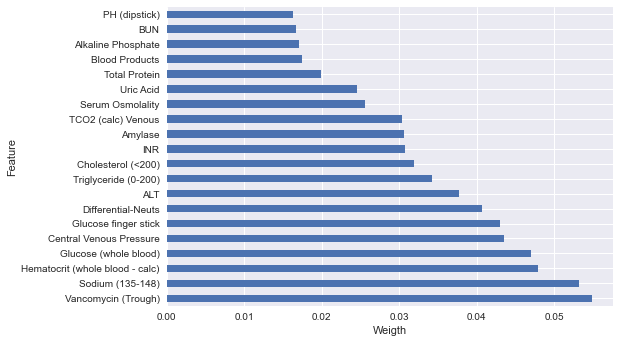

In [35]:
plt.style.use("seaborn")

pd.Series(pipeline.steps[2][1].feature_importances_, index=X.columns.values[:195]).nlargest(20).plot(kind='barh');
plt.xlabel("Weigth")
plt.ylabel("Feature");

The graph shows which features, in this case physiological measurements, are the most relevant regarding the classification model to differentiate from both Heart Failure subtypes. These results could give an interesting idea of which features should be evaluated and could complement standard measurements. 

### Data Imputation Analysis
The impact of the performed imputation is taken into account as it could have an important influence in the modeling results, showing that only around 3% of values in the feature matrix are imputed. 

In [27]:
# print total missing
print('Total: %d' % sum(X.sum()))
# print total missing
print('Missing: %d' % sum(X.isnull().sum()))

print('Percentage: %.3f' % (sum(X.isnull().sum())/sum(X.sum())*100))

# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)
# print total missing
print('Missing: %d' % np.isnan(Xtrans).sum())

Total: 1122215
Missing: 42954
Percentage: 3.828
Missing: 0


In [28]:
sum(X.isnull().sum())/sum(X.sum())*100

3.827605400090949

In [36]:
# Define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=42)

# Define modeling pipeline
clf = RandomForestClassifier()
param_grid = {
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv)
imputer = KNNImputer()
scaler = StandardScaler()
pipeline = Pipeline(steps=[('i', imputer), ('s', scaler), ('m', model)])

# Evaluate model
for i in range(1):
    scores_acc = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    scores_f1 = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores_acc), np.std(scores_acc)))
    print('Mean F1: %.3f (%.3f)' % (np.mean(scores_f1), np.std(scores_f1)))

Mean Accuracy: 0.989 (0.019)
Mean F1: 0.990 (0.021)


## Conclusions
A Classification model is proposed to differentiate Heart Failure subtypes. Specifically, a Random Forest Classifier implement within a pipeline that includes an imputation step. The general accuracy and F1 score of the model show values above 98%. Thus, an analysis of the feature importance for the model is also included, as an analysis of the imputation data process to assess the final results in context. 
The final implemented model accomplishes the classification task proposed.